In [1]:
import pandas as pd 
import prophet

In [9]:
df = pd.read_csv("./cleaned_data.csv")
df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)

df.head(3)

/var/folders/r9/vr40l1ss0v71ty4xxtt_10j00000gn/T/ipykernel_6372/2410422272.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)


,RecordID,Offense,IncidentID,BlockNumber,StreetName,Agency,DateReported,HourReported,ReportingOfficer,InSession,DayOfWeek,TimeOfDay_Adjusted,TimeOfDay
0,1,Assist Citizen,202400034093,900.0,"ELLIOTT AVE, A",CPD,2024-10-02 00:24:02+00:00,2024,"Venereo, Arturo",1,Tuesday,Dusk,Night
1,2,Larceny,202400034075,1600.0,"6TH ST SE, 28",CPD,2024-10-01 21:38:47+00:00,1738,"Kirby, Tyree",1,Tuesday,Noon,Night
2,3,Hit and Run,202400034071,900.0,EMMET ST N,CPD,2024-10-01 21:11:45+00:00,1711,"Bland, Johnnà",1,Tuesday,Noon,Night


In [10]:
# Aggregate data  
df_weekly = df.set_index("DateReported").resample("W").agg({
    "InSession": "max"  # 1 if UVA was in session at least once that week, else 0
}).reset_index() 

# Add the CrimeCount column by counting rows per week
df_weekly["CrimeCount"] = df.resample("W", on="DateReported").size().values

df_weekly.head(10)

,DateReported,InSession,CrimeCount
0,2019-10-06 00:00:00+00:00,1,28
1,2019-10-13 00:00:00+00:00,1,110
2,2019-10-20 00:00:00+00:00,1,125
3,2019-10-27 00:00:00+00:00,1,100
4,2019-11-03 00:00:00+00:00,1,131
5,2019-11-10 00:00:00+00:00,1,100
6,2019-11-17 00:00:00+00:00,1,90
7,2019-11-24 00:00:00+00:00,1,90
8,2019-12-01 00:00:00+00:00,1,73
9,2019-12-08 00:00:00+00:00,1,120


In [13]:
from prophet.make_holidays import make_holidays_df

start_year = 2005
end_year = 2023

# Define UVA-specific "holiday" periods
uva_holidays = []
for year in range(start_year, end_year + 1):
    uva_holidays.extend([
        {"holiday": "Fall semester start", "ds": f"{year}-08-24"},  # Fall semester start
        {"holiday": "Fall semester end", "ds": f"{year}-12-06"}, # Fall semester end
        {"holiday": "Winter break start", "ds": f"{year}-12-07"},  # Winter break start
        {"holiday": "Winter break end", "ds": f"{year}-01-17"}, # Winter break end 
        # {"holiday": "J-term start", "ds": f"{year}-01-03"},  
        # {"holiday": "J-term end", "ds": f"{year}-01-12"},
        {"holiday": "Spring semester start", "ds": f"{year}-01-18"},  
        {"holiday": "Spring semester end", "ds": f"{year}-05-02"},
        {"holiday": "Summer break start", "ds": f"{year}-05-03"},
        {"holiday": "Summer break end", "ds": f"{year}-08-23"}])

# Convert to DataFrame
uva_holidays = pd.DataFrame(uva_holidays)
uva_holidays["ds"] = pd.to_datetime(uva_holidays["ds"])  # Ensure datetime format

# Add window for spillover effect (optional)
uva_holidays["lower_window"] = -3
uva_holidays["upper_window"] = 3  

uva_holidays

,holiday,ds,lower_window,upper_window
0,Fall semester start,2005-08-24,-3,3
1,Fall semester end,2005-12-06,-3,3
2,Winter break start,2005-12-07,-3,3
3,Winter break end,2005-01-17,-3,3
4,Spring semester start,2005-01-18,-3,3
...,...,...,...,...
147,Winter break end,2023-01-17,-3,3
148,Spring semester start,2023-01-18,-3,3
149,Spring semester end,2023-05-02,-3,3
150,Summer break start,2023-05-03,-3,3


In [15]:
df_weekly.head(3)

,DateReported,InSession,CrimeCount
0,2019-10-06 00:00:00+00:00,1,28
1,2019-10-13 00:00:00+00:00,1,110
2,2019-10-20 00:00:00+00:00,1,125


In [20]:
# Rename columns for Prophet
df_weekly = df_weekly.rename(columns={"DateReported": "ds", "CrimeCount": "y"})

# Sort by date
df_weekly = df_weekly.sort_values("ds")

# Ensure 'ds' is in datetime format and remove timezone
df_weekly["ds"] = pd.to_datetime(df_weekly["ds"]).dt.tz_localize(None)

In [21]:
from prophet import Prophet 

# Initialize model
model = Prophet(
    yearly_seasonality=True,  # Enable annual seasonality
    weekly_seasonality=True,  # Enable weekly seasonality
    daily_seasonality=False,  # Disable daily since it's too granular
)

# Add UVA regressor
model.add_regressor("InSession")

# Fit model
model.fit(df_weekly)


19:35:33 - cmdstanpy - INFO - Chain [1] start processing
19:35:34 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
future = model.make_future_dataframe(periods=365, freq="D")  # Predict 1 year ahead

# Add UVA session indicator to future data
future["InSession"] = future["ds"].apply(lambda x: 1 if x.month in [1, 2, 3, 8, 9, 10, 11] else 0)

# Predict
forecast = model.predict(future)

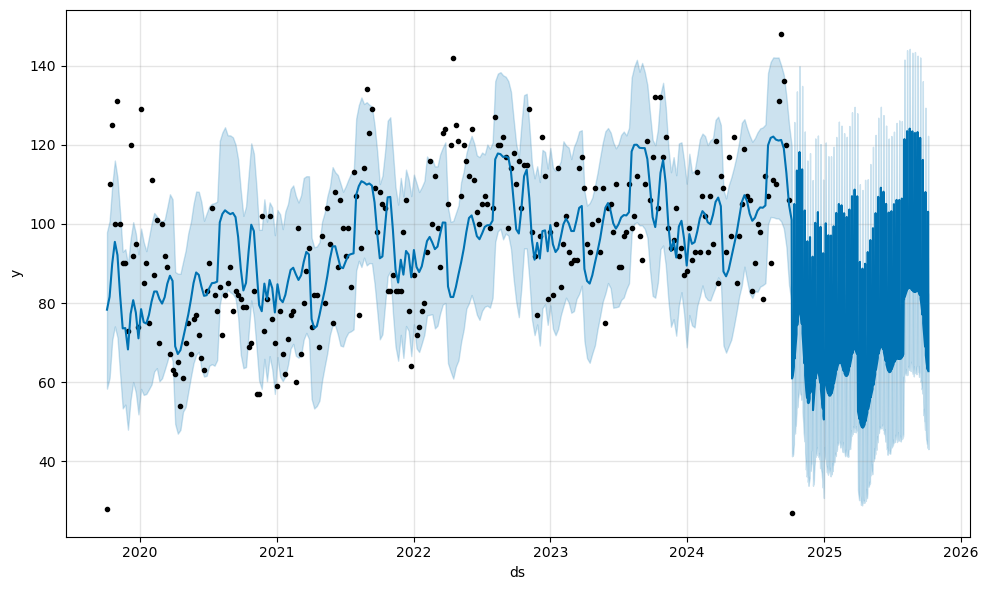

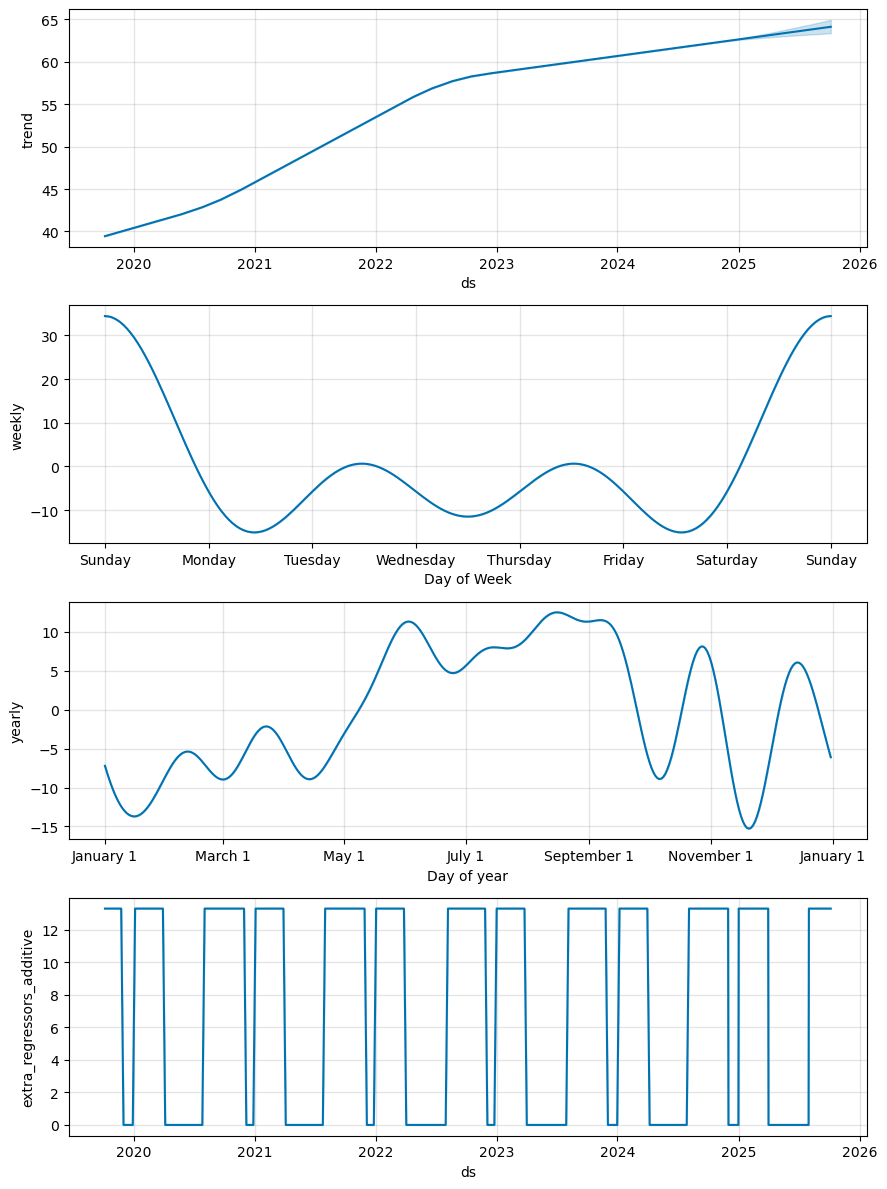

In [24]:
import matplotlib.pyplot as plt

# Plot forecast
fig = model.plot(forecast)
plt.show()

# Plot seasonality components
fig2 = model.plot_components(forecast)
plt.show()


## Evaluate the Model 

In [26]:
from sklearn.metrics import mean_absolute_error

# Use past data for testing
train_size = int(len(df_weekly) * 0.8)
train, test = df_weekly.iloc[:train_size], df_weekly.iloc[train_size:]

model_val = Prophet(
    yearly_seasonality=True,  # Enable annual seasonality
    weekly_seasonality=True,  # Enable weekly seasonality
    daily_seasonality=False,  # Disable daily since it's too granular
)

# Fit on training set
model_val.fit(train)

# Predict on test set
test_forecast = model_val.predict(test)

# Evaluate
mae = mean_absolute_error(test["y"], test_forecast["yhat"])
print(f"Mean Absolute Error: {mae}")


19:45:05 - cmdstanpy - INFO - Chain [1] start processing
19:45:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 12.221739029161725
